# This will be the simulation which tests several different domain sizes/gridspacings for two 1/2 disclinations annihilating

### Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

### Add designated save folder

In [2]:
save_folder = r'two-disclination-compiled-flowless-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

### Import necessary libraries, widgets, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifferenceCompiled as fd
import LiquidCrystalHelperCompiled as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit

import time
import timeit
from importlib import reload

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [4]:
reload(fd)
reload(lch)

<module 'LiquidCrystalHelperCompiled' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelperCompiled.py'>

In [5]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

### Set starting parameters, generate starting auxiliary variables

In [7]:
l = 70
n = 257

S_val = 0.5
ctr = [[-35, 0], [35, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = 70000

first_drop_time = 12.5
annihilation_time = 2460

### Run simulation

In [20]:
profile_filename = os.path.join(save_folder, r'profile.txt')

In [43]:
profile_filename = r'subfoler\profile.txt'
profile_filename

'subfoler\\profile.txt'

In [39]:
%prun -s cumulative -q -T $profile_filename print('Hello World')

Hello World
 
*** Profile printout saved to text file '$profile_filename'. 


In [17]:
%%prun -s cumulative -q -T profile_filename

num_defects = 2
peak_pos_x = np.zeros((num_defects, num_steps))
peak_pos_y = np.zeros((num_defects, num_steps))
peak_val = np.zeros((num_defects, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)
n_steps_update_progress = 1000

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

first_drop = False
halfway = False
start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peak_val[:, i], peak_pos_x[:, i], peak_pos_y[:, i] = lch.findDefects(lambda_max, X, Y, num_defects)
        
    t[i] = i*dt
    
    if i*dt > first_drop_time and not first_drop:
        eta_fd = eta_old
        mu_fd = mu_old
        nu_fd = nu_old
        first_drop = True
    if i*dt > annihilation_time/2 and not halfway:
        eta_hw = eta_old
        mu_hw = mu_old
        nu_hw = nu_old
        halfway = True
    
    
    # Update loading bar
    if i % n_steps_update_progress == 0:
        progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos_x = peak_pos_x[:, :i]
peak_pos_y = peak_pos_y[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=70000)

Simulation ran in 2.9295795200000003 minutes.
 
*** Profile printout saved to text file '$profile_filename'. 


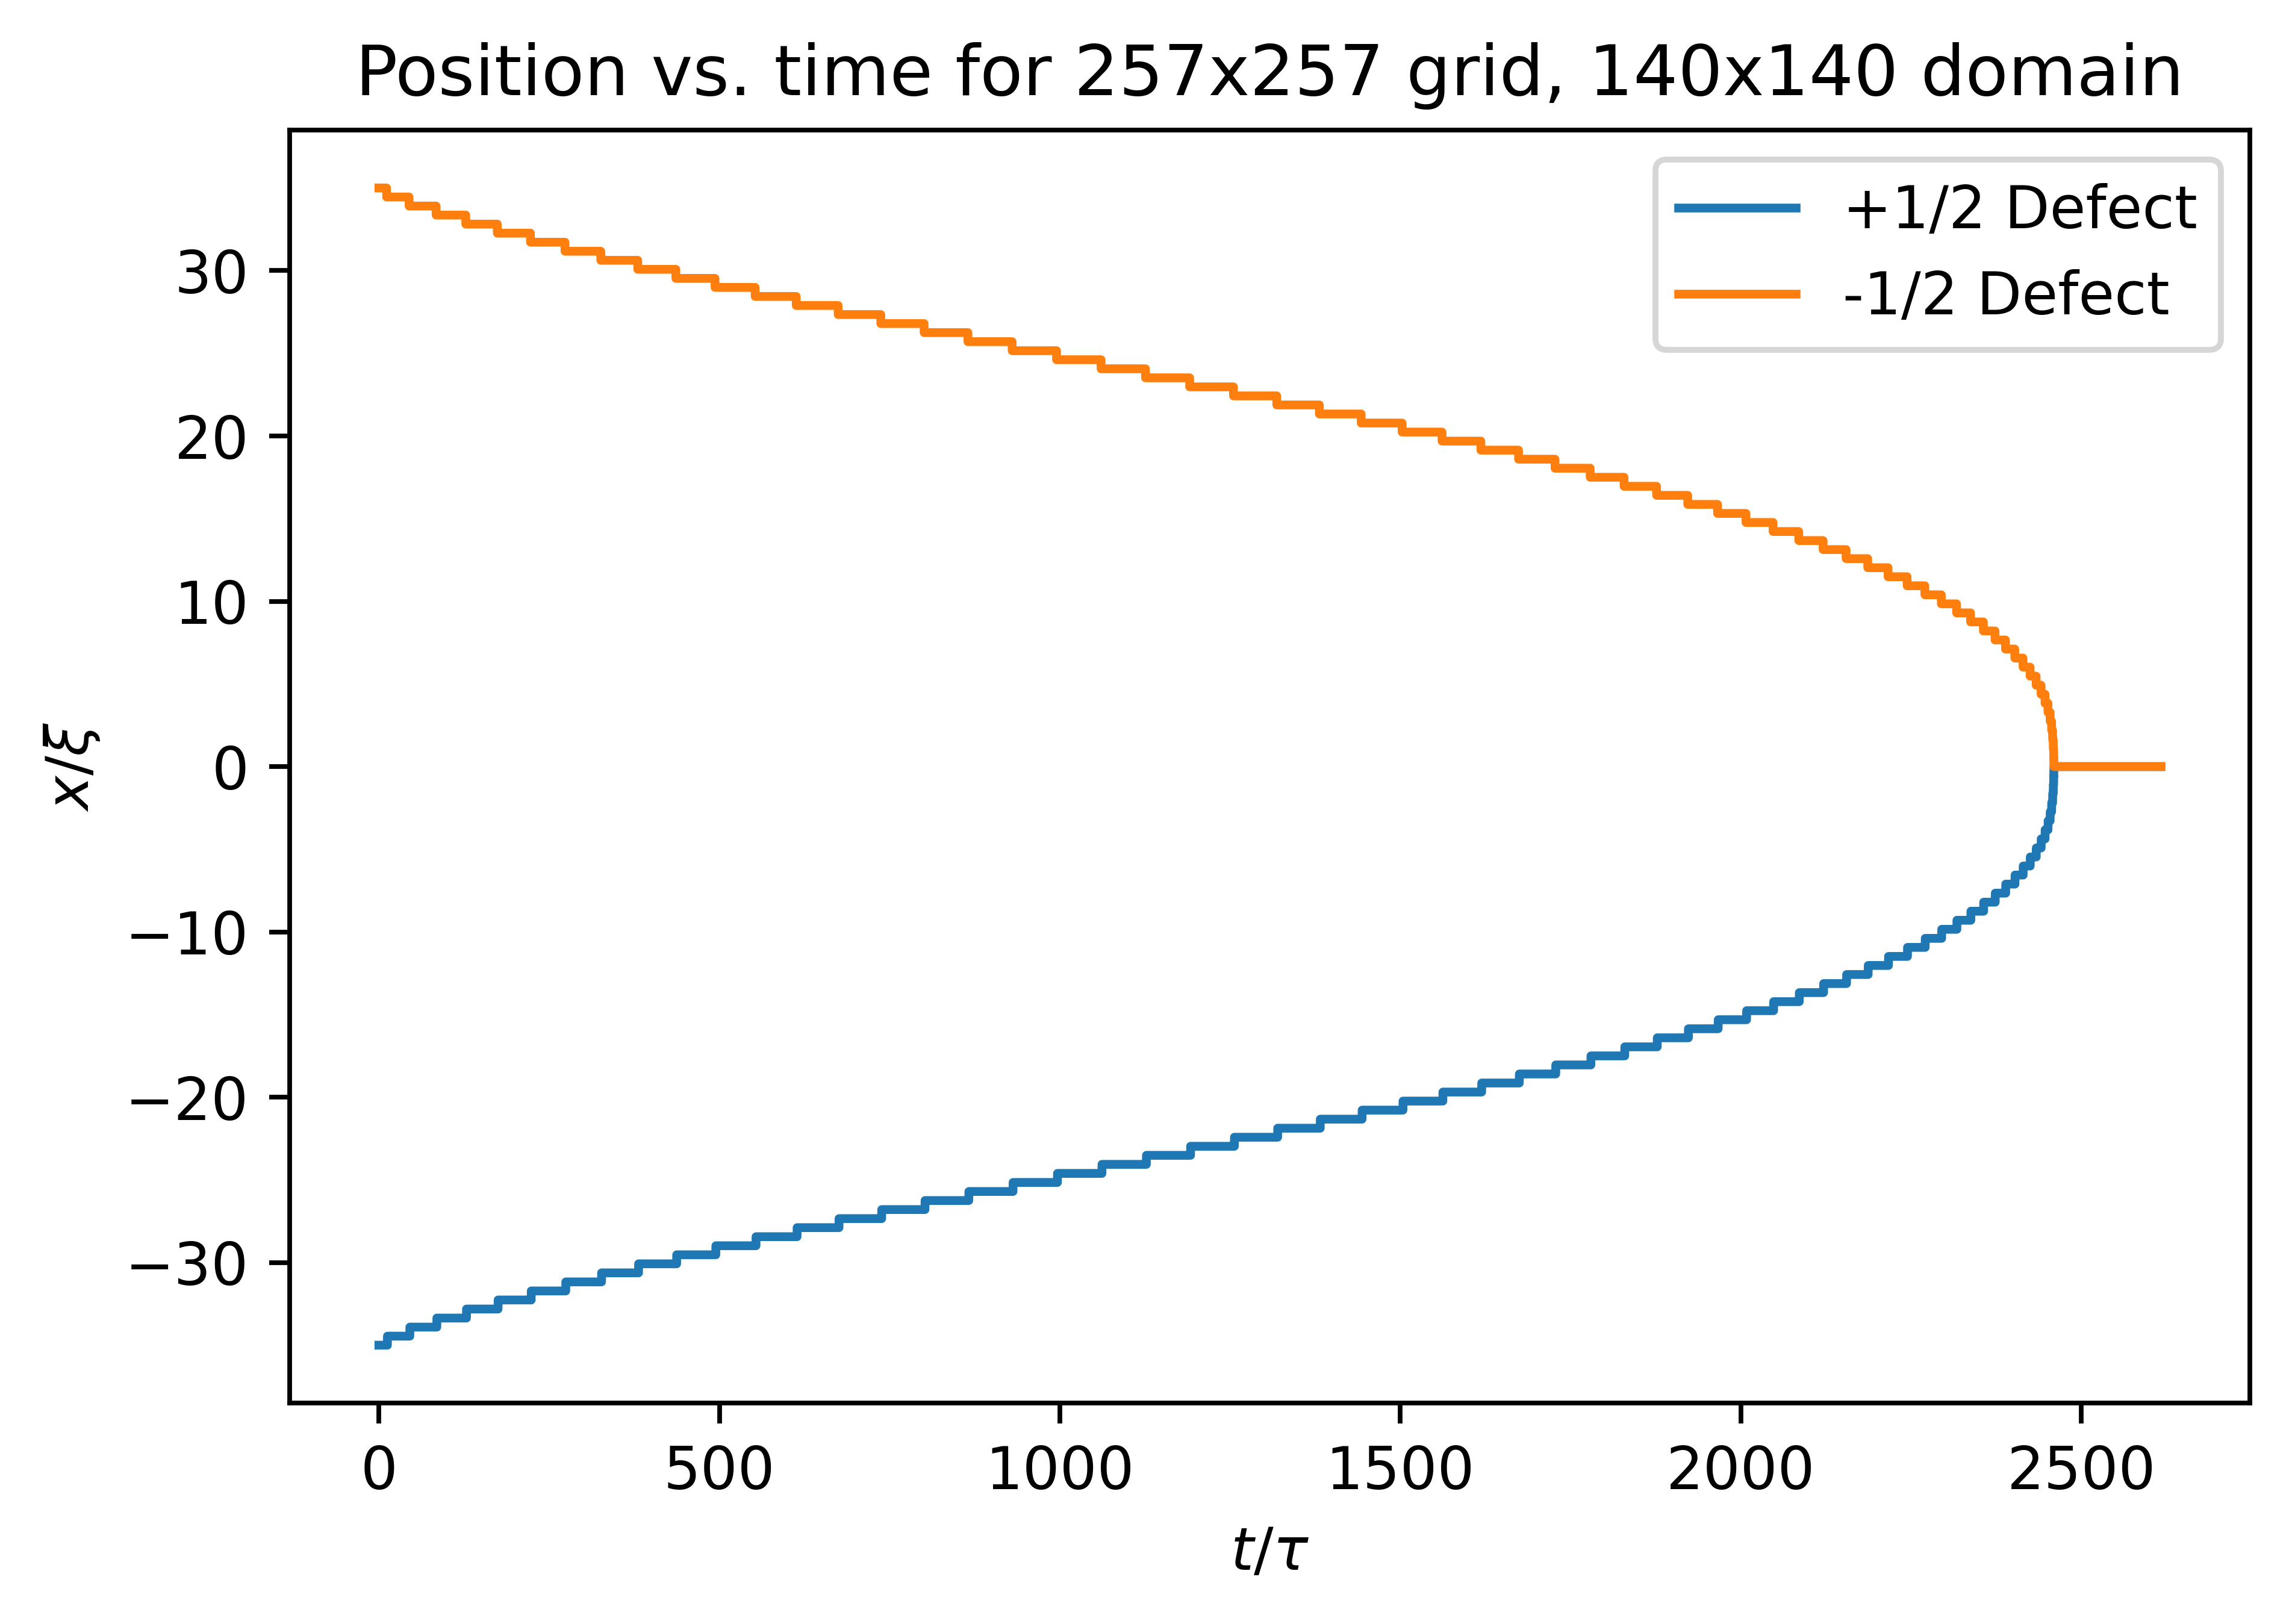

In [12]:
plt.plot(t, peak_pos_x[0, :], label='+1/2 Defect')
plt.plot(t, peak_pos_x[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid, 140x140 domain')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-140x140-domain.png')
plt.savefig(filename_defect_pos_vs_time)

In [13]:
print("Defects annihilate at", t[np.where(peak_pos_x[0, :] == 0)[0][0]], "t/tau")
print("First Drop is at", t[np.where(np.diff(peak_pos_x[0, :]) > 0)[0][1]], "t/tau")

Defects annihilate at 2459.6450805664062 t/tau
First Drop is at 45.421600341796875 t/tau


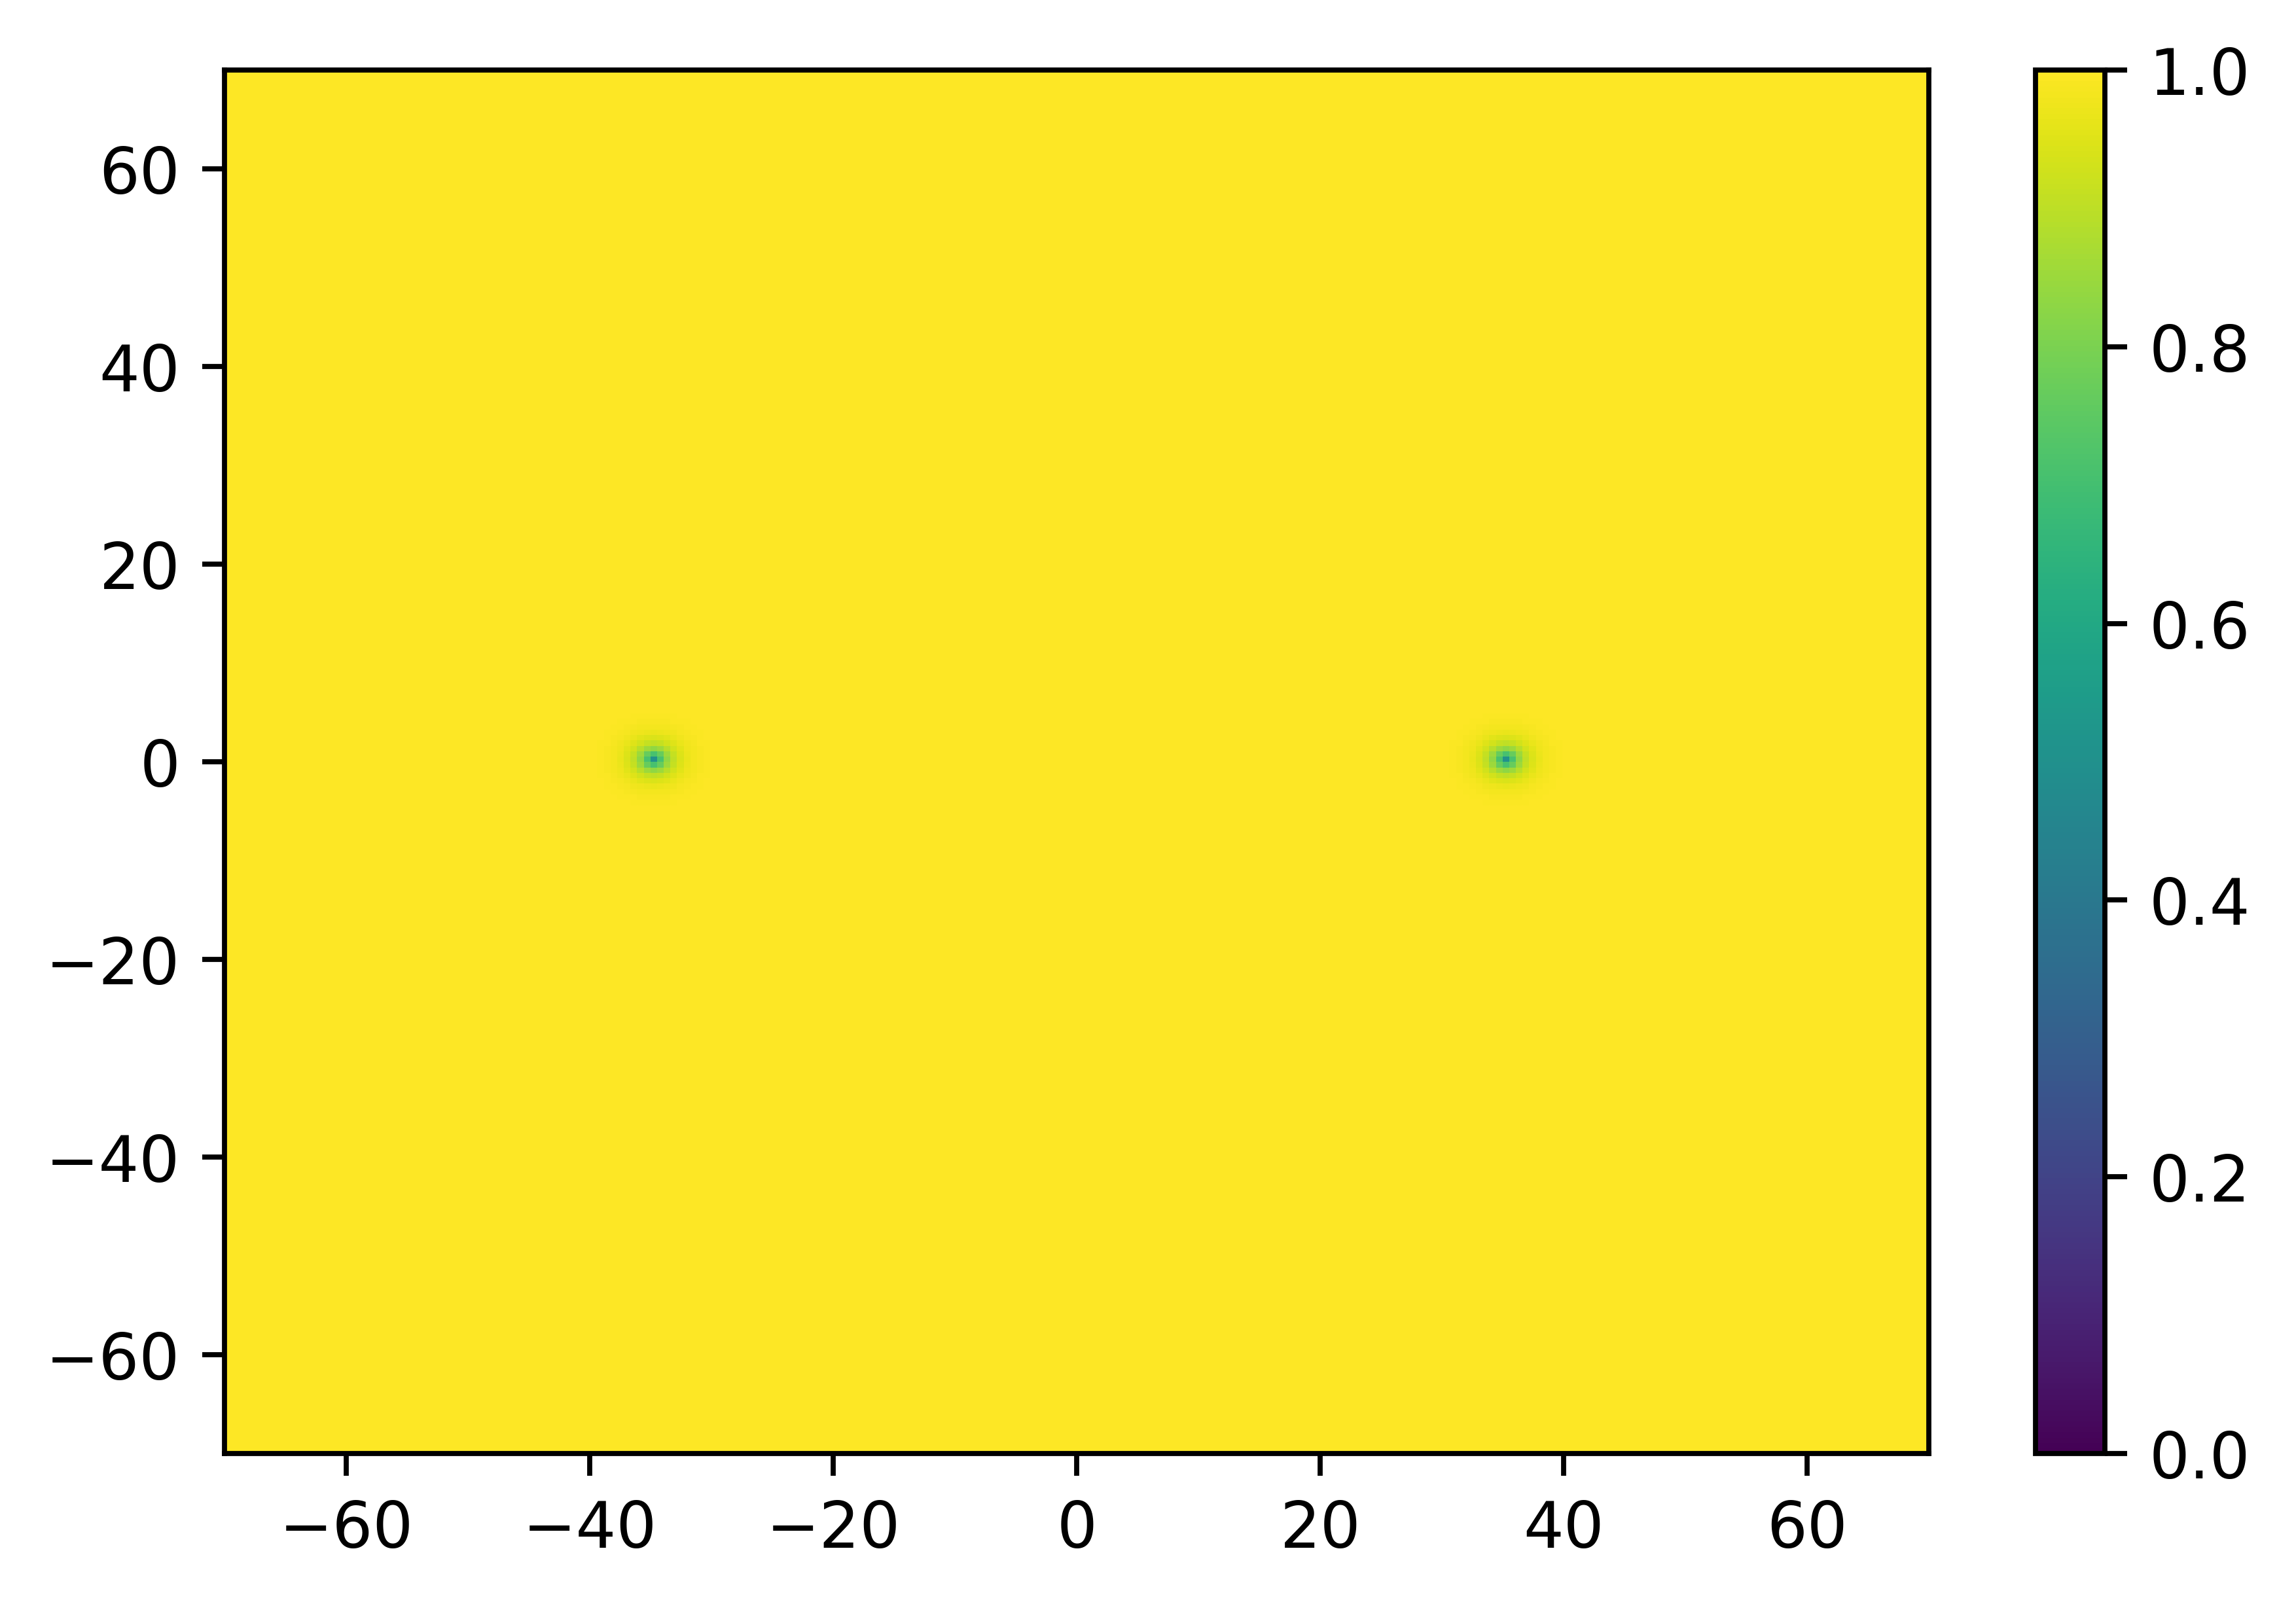

In [14]:
lambda_max_b = lch.calcQEigenvals(eta, mu, nu)
plt.pcolor(X, Y, lambda_max_b, vmin=0, vmax=1)
plt.colorbar()

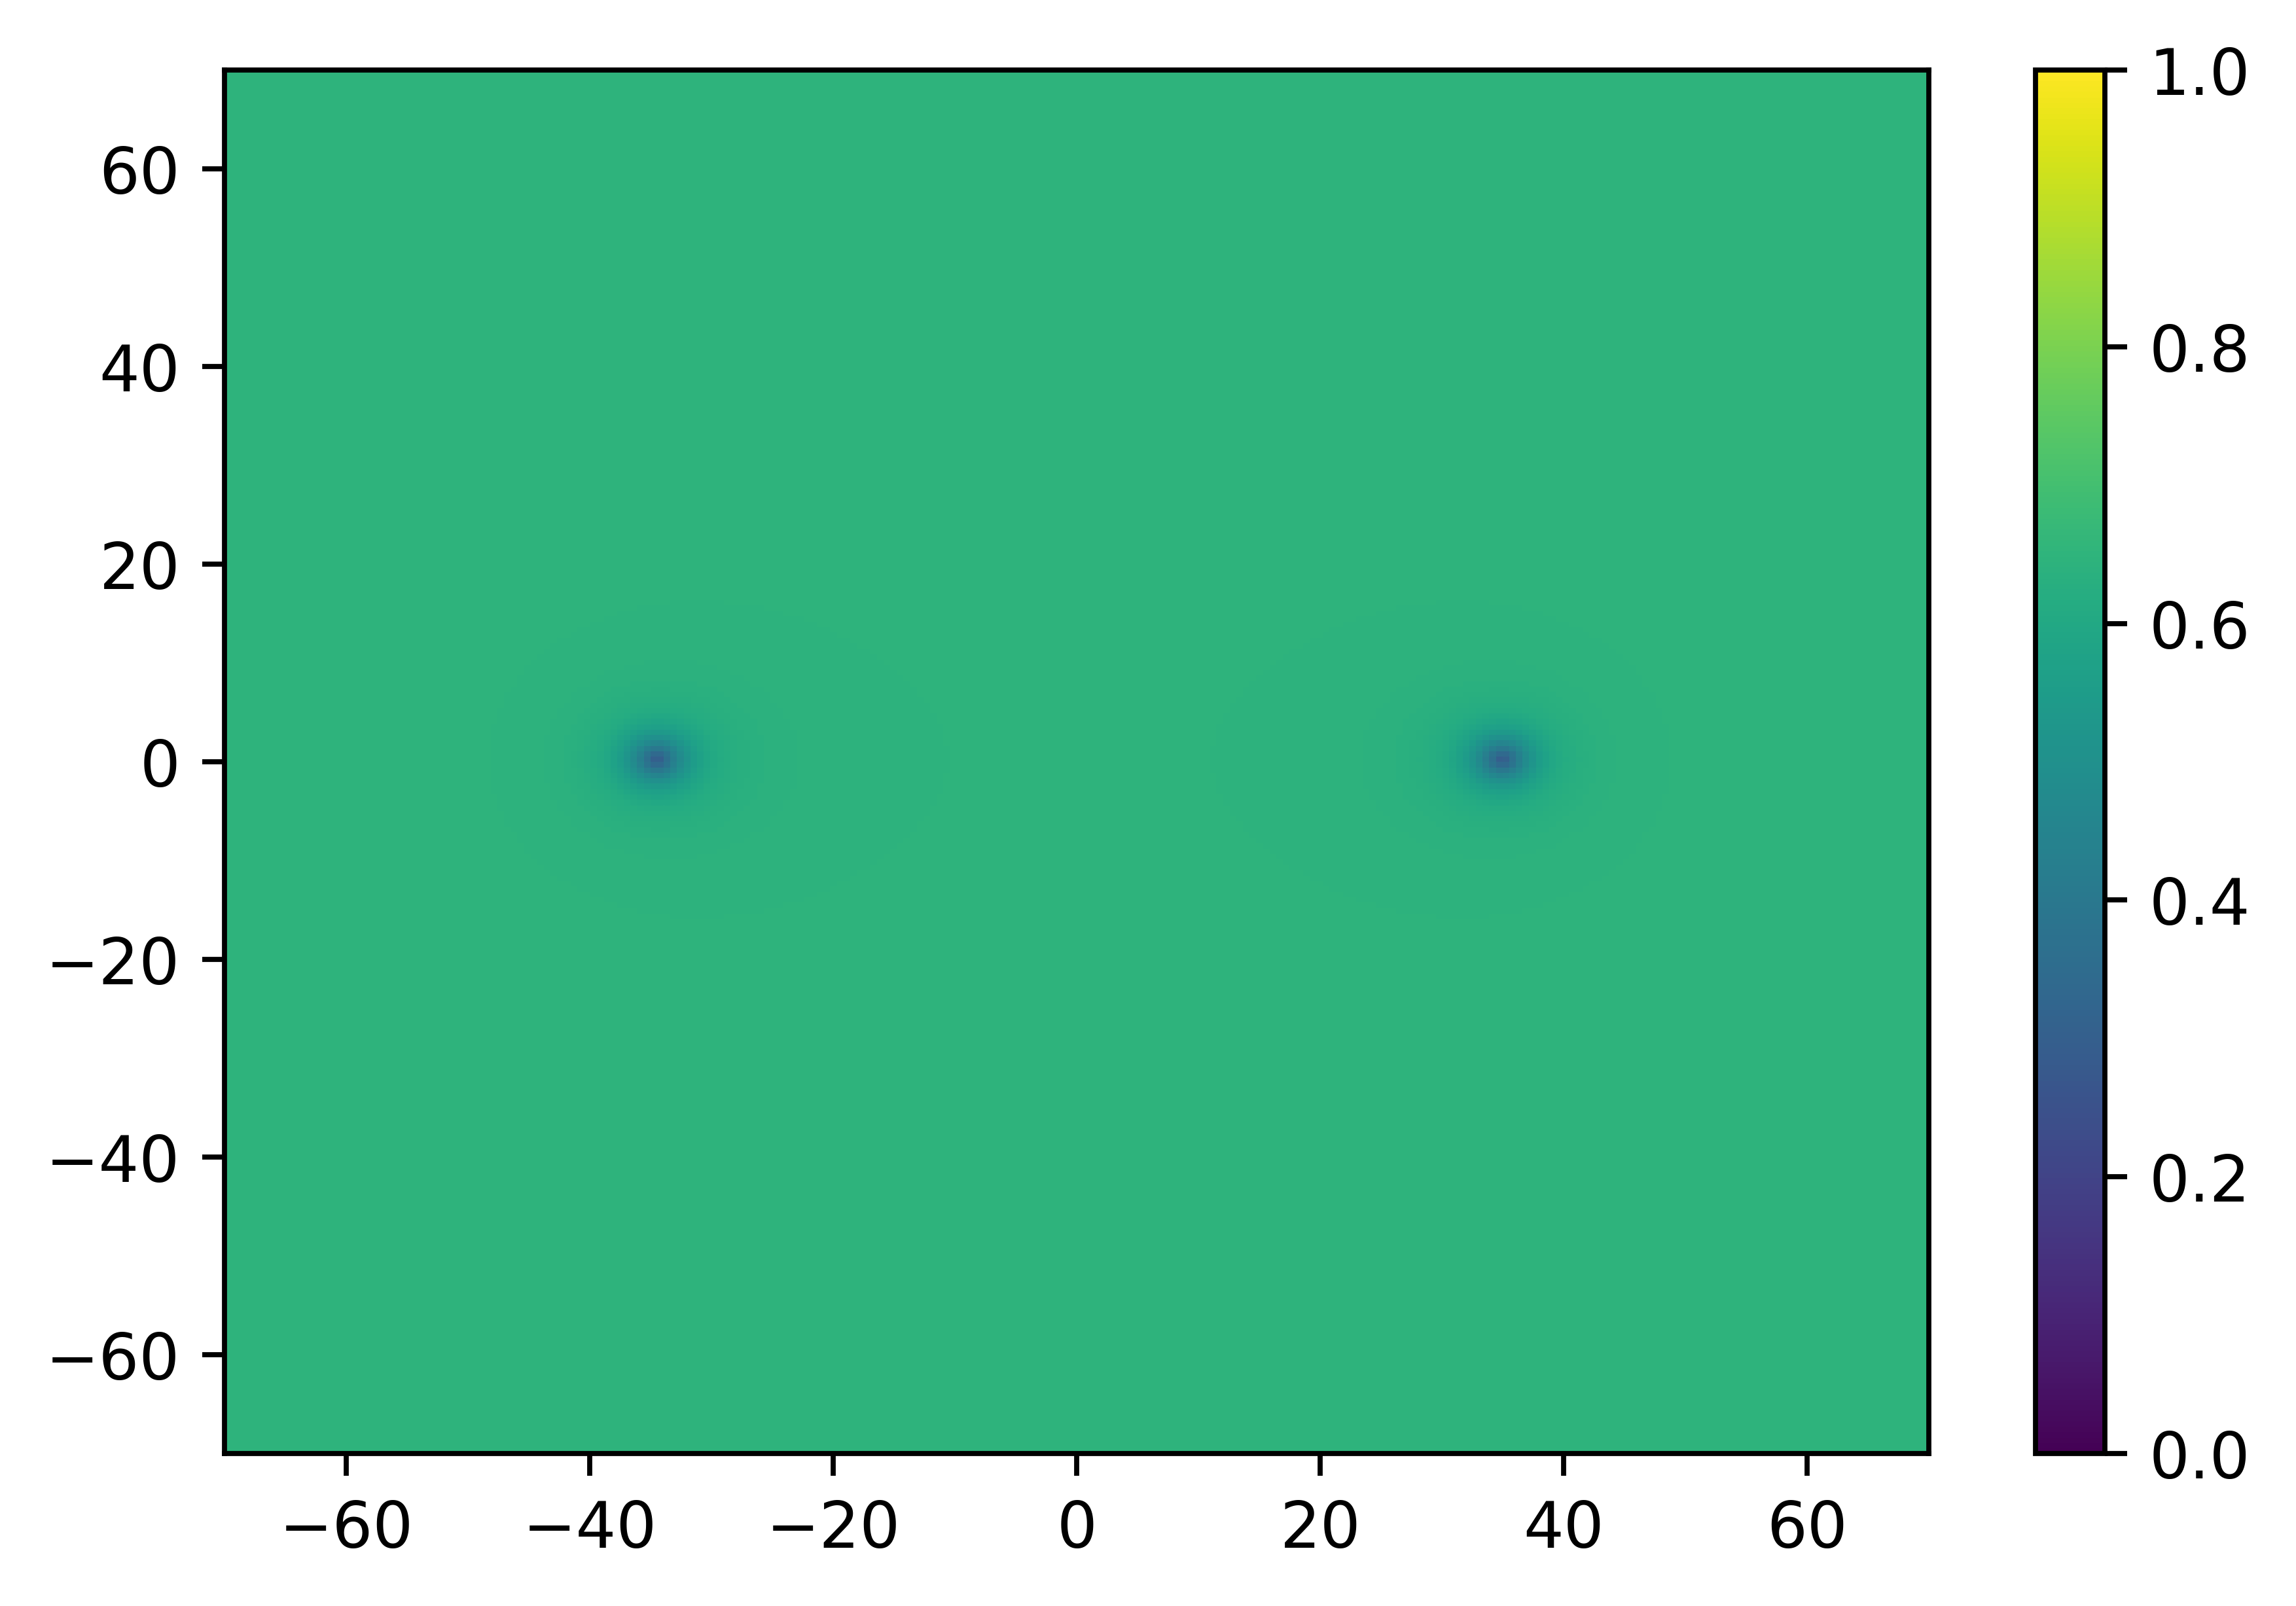

In [15]:
lambda_max_fd = lch.calcQEigenvals(eta_fd, mu_fd, nu_fd)
plt.pcolor(X, Y, lambda_max_fd, vmin=0, vmax=1)
plt.colorbar()

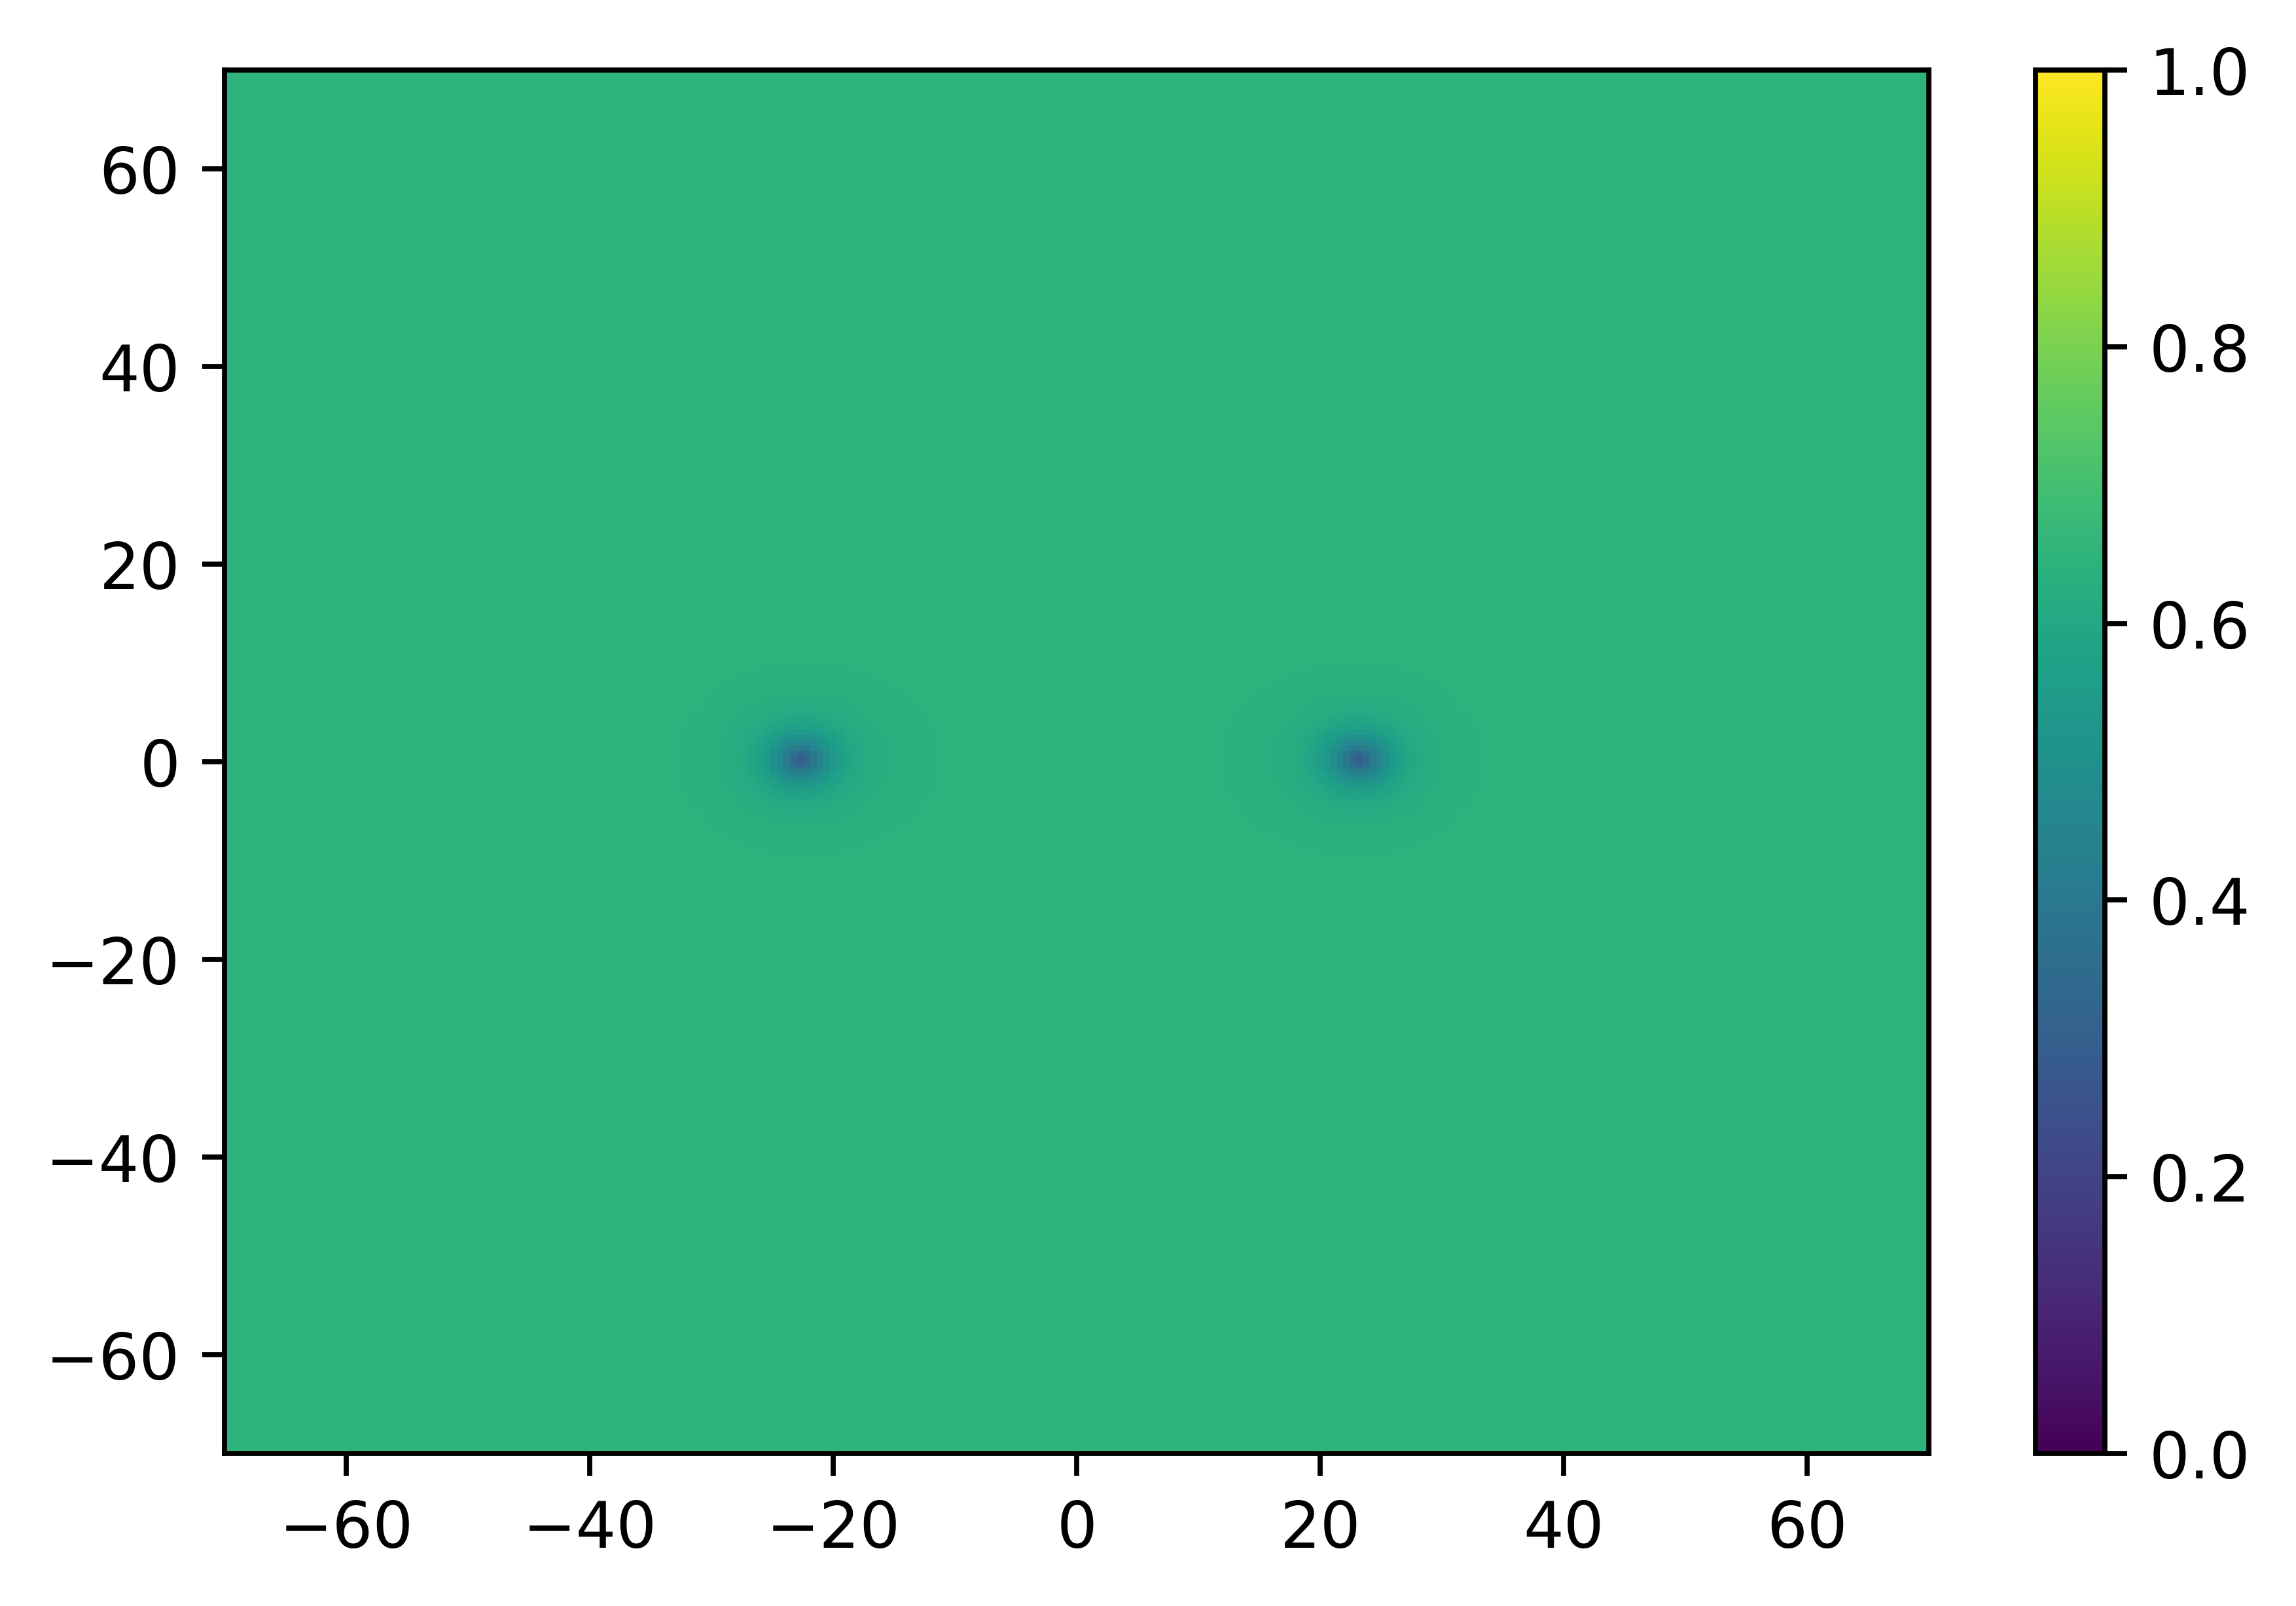

In [16]:
lambda_max_hw = lch.calcQEigenvals(eta_hw, mu_hw, nu_hw)
plt.pcolor(X, Y, lambda_max_hw, vmin=0, vmax=1)
plt.colorbar()

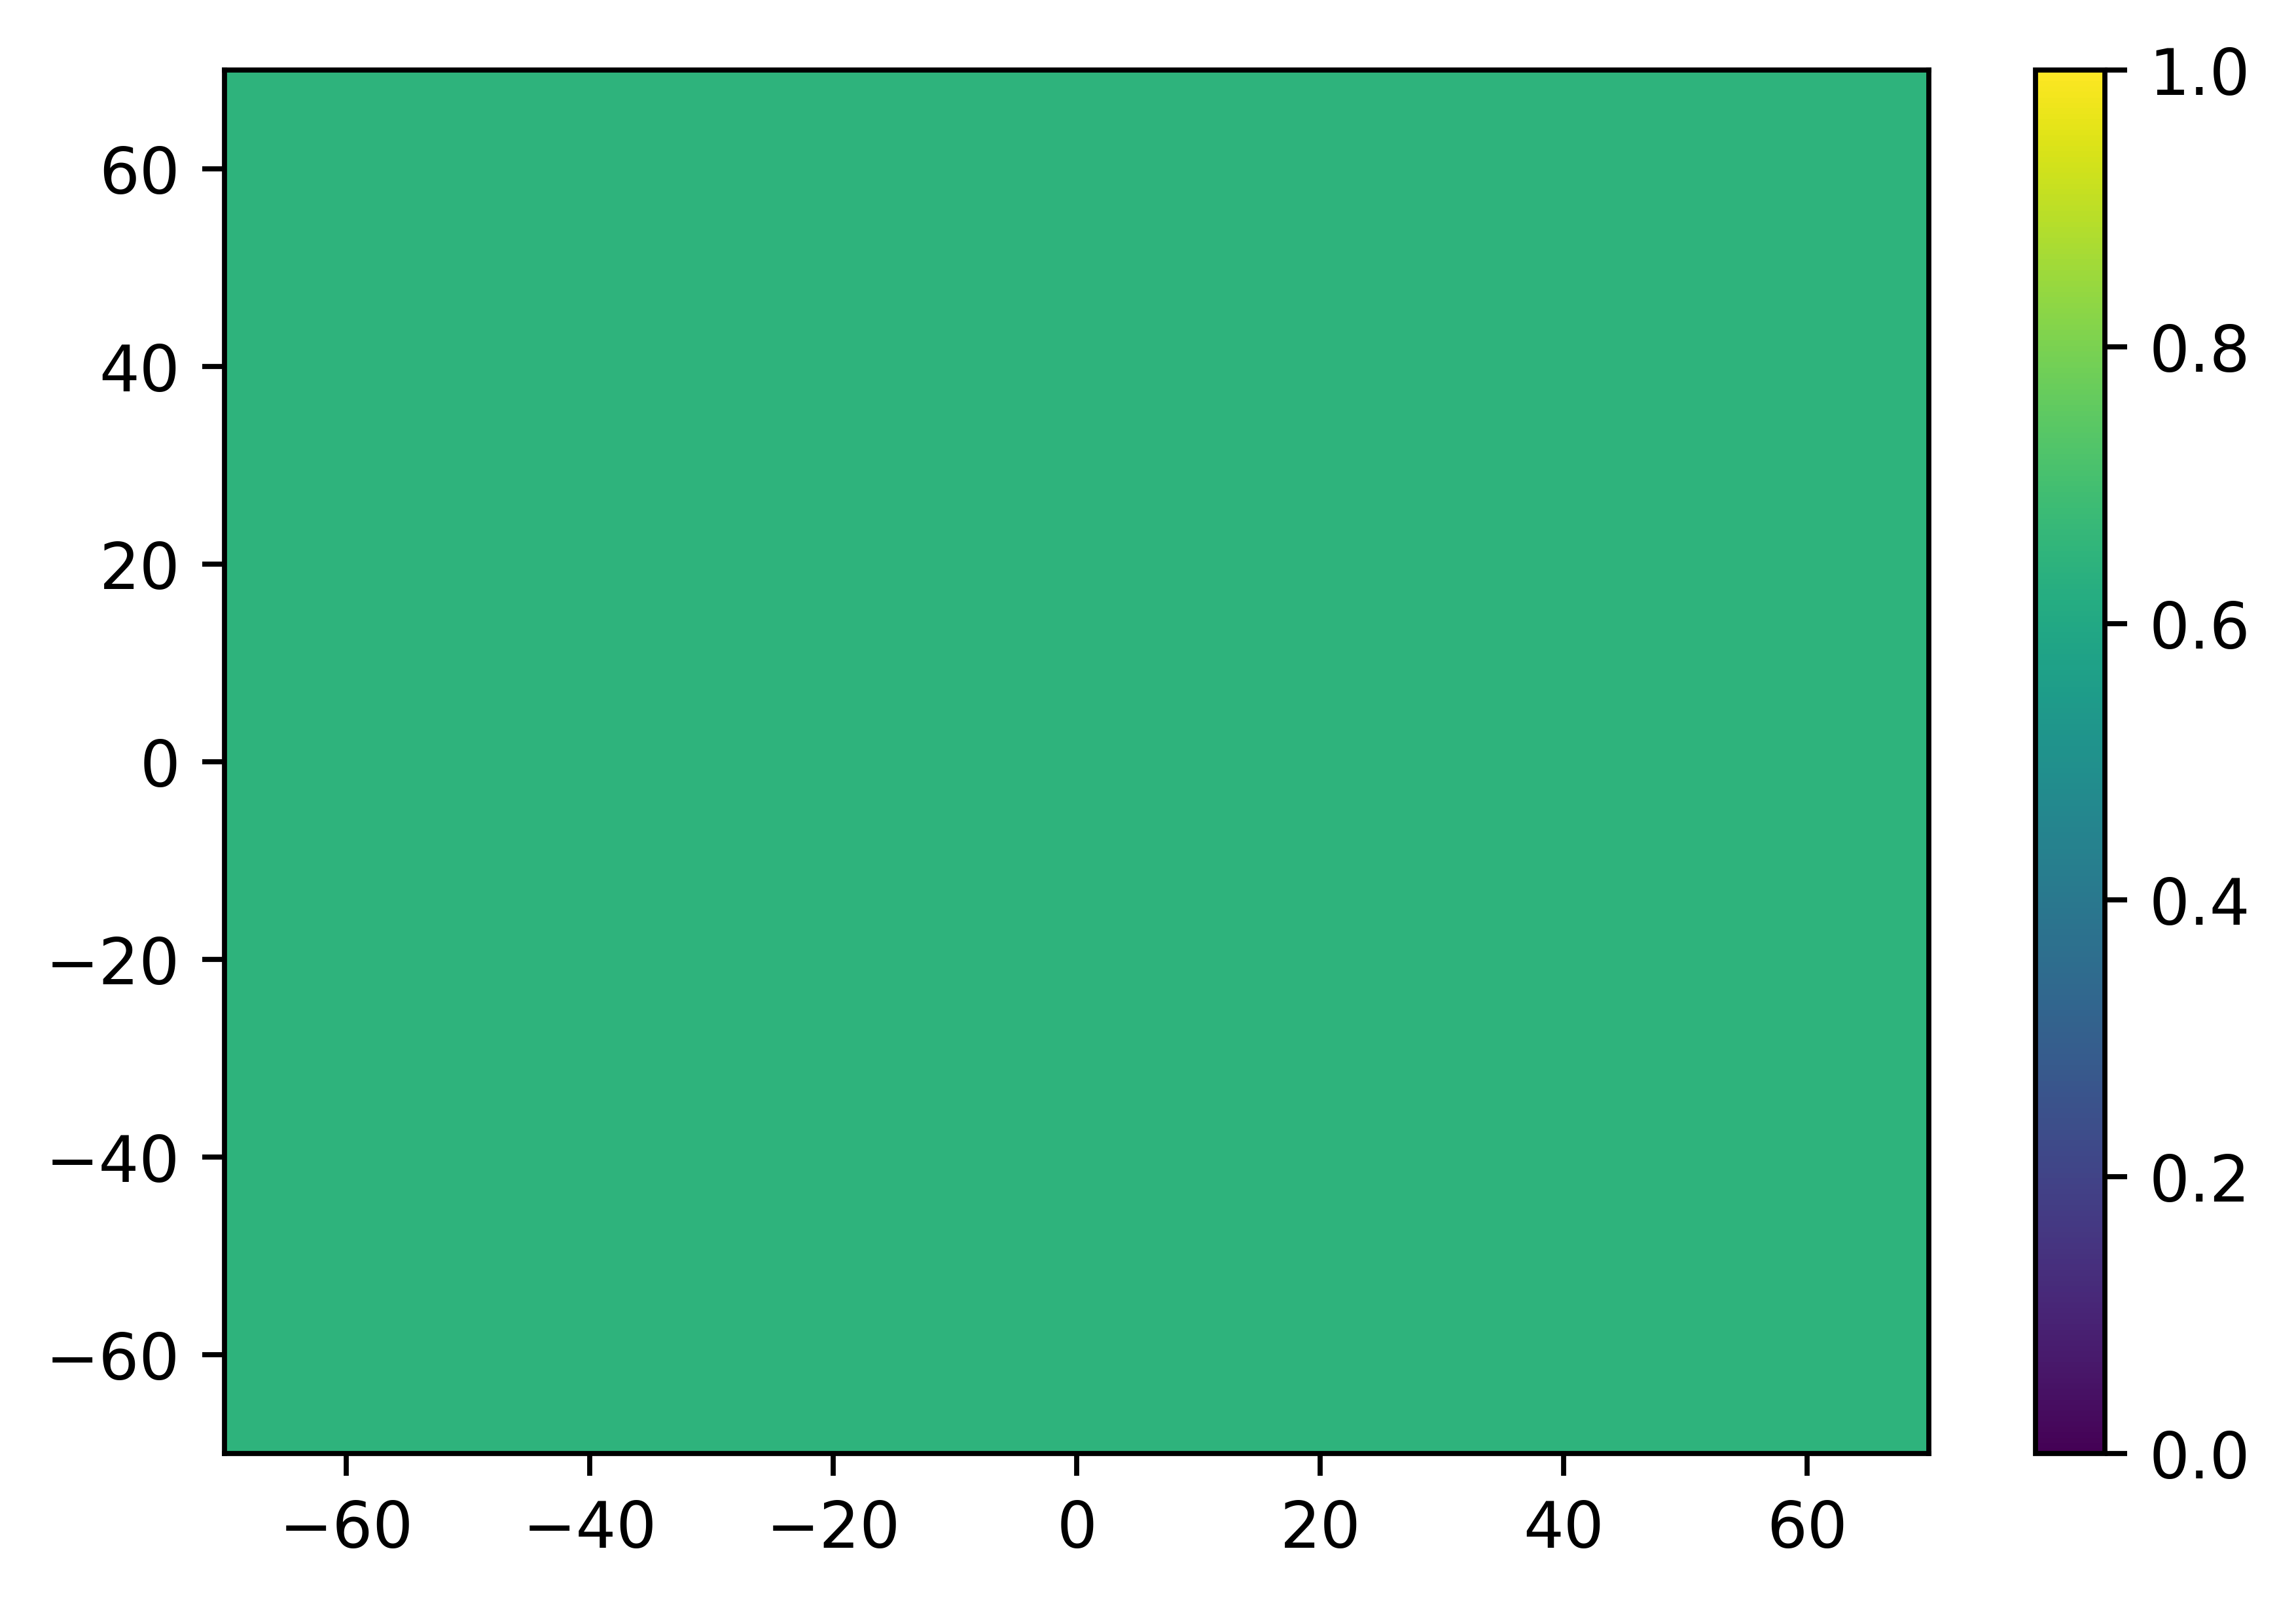

In [17]:
lambda_max_end = lch.calcQEigenvals(eta_old, mu_old, nu_old)
plt.pcolor(X, Y, lambda_max_end, vmin=0, vmax=1)
plt.colorbar()

# Put all important arrays into a dictionary and store them in a .pickle file

In [18]:
all_arrays = {'t': t,
              'peak_pos_x': peak_pos_x,
              'peak_pos_y': peak_pos_y,
              'eta_old': eta_old,
              'mu_old': mu_old,
              'nu_old': nu_old,
              'eta_fd': eta_fd,
              'mu_fd': mu_fd,
              'nu_fd': nu_fd,
              'eta_hw': eta_hw,
              'mu_hw': mu_hw,
              'nu_hw': nu_hw,
              'eta': eta,
              'mu': mu,
              'nu': nu}

In [19]:
import dill
filename_pickle = os.path.join(save_folder, r'two-disclination-flowless-simulation.pickle')

with open(filename_pickle, 'wb') as f:
    dill.dump(all_arrays, f)

In [21]:
with open(filename_pickle, 'rb') as f:
    new_all_arrays = dill.load(f)